In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy import stats
import psycopg2
from sqlalchemy import create_engine

In [2]:
class TELECOM :
    # ===== INITIALIZING OR CONSTRUCTOR =====#
    def __init__(self,filepath):
        self.filepath = filepath            # Store the file path
        self.data = pd.read_csv(filepath)   # Load CSV into a DataFrame

    # ===== BASIC INSPECTION ===== #
    
    """ Displays dataset """
    def Dataframe(self):
        return self.data
        
    """ Information of the dataset """
    def Basic_info(self):
        return self.data.info()

    """ rows and columns count """
    def Count_of_rows_columns(self):
        return self.data.shape

    """ Indexing """
    def indexing(self):
        return self.data.index

    """ Display first 10 rows """
    def Starting_rows(self):
        return self.data.head(10)

    # ===== DATA CLEANING ===== #

    """ Checking null values """
    def null_value_sum(self):
        return self.data.isnull().sum()

    """ Detecting duplicates """
    def Duplicates(self):
        return self.data.apply(lambda x: x.duplicated())

    # ===== DATA TRANSFORMATION ===== #

    """Returns count of customers grouped by Partner status"""
    def Customer_count(self,col1,col2):
        return self.data.groupby(col1)[col2].count().reset_index()

    """Returns churn counts"""
    def churn_rate(self,col):
        """Returns churn counts"""
        return self.data[col].value_counts().reset_index()
        
    """Returns senior citizen percentage"""
    def senior_citizen_percent(self,col):
        return self.data[col].mean()*100
        
    """ Gender counts """
    def gender_counts(self,col):
        return self.data[col].value_counts().reset_index()

    """ Rate of partner's are in """
    def partner(self,col):
        partner_rate = (self.data[col] == 'Yes').mean()*100
        return partner_rate
        
    """ Count of the contracts """
    def contract_counts(self,col):
        return self.data[col].value_counts().reset_index()
        
    """ payment method counts"""
    def payment_method(self,col):
        return self.data[col].value_counts().reset_index()
        
    """ avg tenure"""
    def avg_tenure(self,col):
        return self.data[col].mean()
        
    """Convert the 'TotalCharges' column to numeric type, coercing errors to NaN."""
    def type_conversion(self,col):
        self.data[col] = pd.to_numeric(self.data[col], errors='coerce')

    # ===== STATISTICAL ANALYSIS ===== #

    """ statistical information of the dataframe """
    def Stat_info(self):
        return self.data.describe()

    """ Measures of central tendency """
    def Statistical_measures(self):
        numeric_cols = self.data.select_dtypes(include=['int64', 'float64']).columns
        measures = []
    
        for col in numeric_cols:
            measures.append({
            'Column': col,
            'Mean': self.data[col].mean(),
            'Median': self.data[col].median(),
            'Mode': self.data[col].mode()[0],
            'Variance': self.data[col].var(),
            'Std_Dev': self.data[col].std()
        })
    
        return pd.DataFrame(measures)

    """ correlation between two columns """
    def Corr_coef(self,col1,col2):
        return np.corrcoef(self.data[col1],self.data[col2])[0][1]

    """ correlation among all the numeric columns with target """
    # correlation among the columns with target column
    # integer columns
    def Correlation(self):
        continious_var = self.data.select_dtypes(include=['int64','float64']).columns.tolist()
        correlated = []
        target = 'MonthlyCharges'

        for col in continious_var:
            if col != target:  #  comparing all continious variable columns  with target
                result = np.corrcoef(self.data[col], self.data[target])[0][1]
                if abs(result) :
                    correlated.append((col, target, round(result, 3)))
            
        # Print results
        for pair in correlated:
            print(f"{pair[0]} vs {pair[1]}  => correlation: {pair[2]}")

        return 
    
    """ Anova among all the categorical variables with target """
    # Anova 
    # categorical columns
    def Anova(self):
        if 'customerID' in self.data.columns:
            self.data = self.data.drop(columns = 'customerID')
        target = 'MonthlyCharges'
    
        # Select categorical columns
        categorical_var = self.data.select_dtypes(include=['object']).columns
    
        for col in categorical_var:
            groups = [group[target].values for name, group in self.data.groupby(col)]
        
            # Filter out empty or single-value groups
            groups = [g for g in groups if len(g) > 1]
        
            if len(groups) >= 2:  # At least 2 valid groups
                f_stat, p_val = stats.f_oneway(*groups)
                print(f"ANOVA for {col}: F = {f_stat:.3f}, p = {p_val:.3e}")
            else:
                print(f"Skipping {col}: Not enough data for ANOVA")
        return 


    """ chi-square test for all category columns with target column"""
    def Chi_square(self):
        target = 'InternetService'
    
        categorical_vars = self.data.select_dtypes(include=['object', 'category']).columns.tolist()
        results = []
    
        for col in categorical_vars:
            if col == target:
                continue
        
            table = pd.crosstab(self.data[col], self.data[target])
        
            if table.shape[0] > 1 and table.shape[1] > 1:
                chi2, p, dof, expected = chi2_contingency(table)
                interpretation = 'Significant' if p < 0.05 else 'Not Significant'
            
                results.append({
                'Variable': col,
                'Chi2': round(chi2, 3),
                'p-Value': format(p, '.3e'),
                'DF': dof,
                'Interpretation': interpretation
                })
    
        return pd.DataFrame(results).sort_values(by='p-Value').reset_index(drop=True)
    
    """ calculating outliers """
    def Outliers(self, col):
        Q1 = self.data[col].quantile(0.25)
        Q3 = self.data[col].quantile(0.75)
        IQR = Q3 - Q1 # inter quartile range
    
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    
        outliers = self.data[(self.data[col] < lower_bound) | (self.data[col] > upper_bound)]
        print(f"Lower Bound: {lower_bound}")
        print(f"Upper Bound: {upper_bound}")
        print(f"Number of outliers: {len(outliers)}")
        return
    
  
    # ===== PLOTTING METHODS ===== #
    
    """ Box plot for multiple columns """
    def Box_plot(self, columns):
        plt.figure(figsize=(12,8))
        sns.boxplot(data=self.data[columns], palette="Set2")
        plt.title("Box Plot of charges")
        plt.xlabel("charges")
        plt.ylabel("count")
        plt.show()

    """ violin plot for policy deductible by policy state """
    def violin_plot(self, col1, col2):
        plt.figure(figsize=(12,8))
        sns.violinplot(data=self.data, x= col1, y= col2, palette="Set3")
        plt.title(f"Distribution of {col2} by {col1}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.xticks()
        plt.show()

    """ Scatter plot of Customer Age vs Claims """   
    def Scatter_plot(self,col1,col2):
        plt.figure(figsize=(12,8))
        sns.scatterplot(data=self.data, x= col1, y= col2, hue= col2 , palette="viridis")
        plt.title(f"Scatter Plot of {col2} vs {col1}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.xticks()
        plt.show()
    
    """ heatmap for numeric data correlation """
    def heat_map(self):
        numeric_df = self.data.select_dtypes(include=np.number)
        corr = numeric_df.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.show()

        
    """Visualize number of customers in each tenure category using a countplot """
    def plot_tenure_group(self):
        sns.countplot(x='TenureGroup', data=self.data)
        plt.xlabel('Tenure Group (months)')
        plt.ylabel('Number of Customers')
        plt.title('Customers per Tenure Group')
        plt.show()
        
    """Plot a bar chart showing churn counts split by contract type."""
    def bar_chart_churn_by_contract(self):
        sns.countplot(x='Contract', hue='Churn', data=self.data)
        plt.title('Churn by Contract Type')
        plt.show()
        
    """Generate a countplot visualizing overall churn distribution """
    def Churn_countplot(self):
        sns.countplot(x='Churn', data=self.data)
        plt.title('Churn Distribution')
        plt.show()
        
    """ Create a 3D scatter plot using Plotly for the specified dimensions """
    def Surface_plot(self, col1, col2, col3):
        plt = px.scatter_3d(
            self.data,
            x= col1,
            y= col2,
            z= col3,
            color= col2,
            size_max=10,
            opacity=0.8,
            title='3D Plot for MonthlyCharges, tenure, TotalCharges ',
            labels={
                'MonthlyCharges': 'MonthlyCharges',
                'tenure': 'tenure',
                'TotalCharges': 'TotalCharges'}
        )
        plt.show()
        
    """ Plot a pie chart visualizing the distribution of categories in the specified column """
    def plot_pie_chart(self, col):
        counts = self.data[col].value_counts()
        plt.figure(figsize=(7,7))
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
        plt.title(f'Distribution of {col}')
        plt.axis('equal')
        plt.show()

    """
        Draw a pairplot of tenure, MonthlyCharges, and TotalCharges.
        Colors data points by 'Churn' status for visual feature comparison.
    """
    def pairplot(self):
        sns.pairplot(self.data, hue='Churn', vars=['tenure', 'MonthlyCharges', 'TotalCharges'])
        plt.show()


    """ Connecting python to postgresql """
    """ ------------------ POSTGRESQL INTEGRATION ------------------ """
    @staticmethod
    def infer_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"
            
            
    """ Generates SQL CREATE TABLE statement based on DataFrame column dtypes"""
    def generate_create_table_statement(self, table_name="telecom_data"):
        """  SQL CREATE TABLE statement """
        columns = self.data.dtypes
        sql_columns = ",\n    ".join([f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()])
        create_stmt = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
        {sql_columns}
        );
        """
        return create_stmt


    def save_to_postgres(self, conn_params, table_name="telecom_data"):
        """
        Creates table and inserts DataFrame records into PostgreSQL.
        Name of the PostgreSQL table "telecom_data".
        """
        create_stmt = self.generate_create_table_statement(table_name)

        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            
            # Create the table
            cur.execute(create_stmt)
            conn.commit()
            
            # Prepare insert statement
            columns = list(self.data.columns)
            placeholders = ', '.join(['%s'] * len(columns))
            insert_stmt = f"""
            INSERT INTO {table_name} ({', '.join(['"{}"'.format(col) for col in columns])})
            VALUES ({placeholders})
            """
            # Insert data row by row
            for _, row in self.data.iterrows():
                cur.execute(insert_stmt, tuple(row))
            conn.commit()
            
            cur.close()
            conn.close()
            print(f"Data inserted successfully into table {table_name}")
            
        except Exception as e:
            print(f"Error during PostgreSQL operation: {e}")

                    
    """ Reads data from a PostgreSQL table and returns a Pandas DataFrame """
    def read_from_postgresql(self, conn_params=None, table_name="telecom_data"):
        
        if conn_params is None:
            conn_params = {
                'dbname': "postgres",
                'user': "postgres",
                'password': "postgres",
                'host': "localhost",
                'port': "5432"
            }

        try:
            conn = psycopg2.connect(**conn_params)
            query = f'SELECT * FROM {table_name}'
            df = pd.read_sql(query, conn)
            conn.close()
            return df
        except Exception as e:
            print(f" Error reading from PostgreSQL: {e}")
            return None



In [3]:
# object creation
tel = TELECOM("telecom_data.csv")

# BASIC INSPECTION


In [4]:
# Dataframe
tel.Dataframe()

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL             No  ...   
1             Yes                No             DSL            Yes  ...   
2             Yes                No             DSL            Yes  ...   
3              No  No phone service             DSL            Yes  ...   
4             Yes                No     Fiber optic             No  ...   
...           ...               ...             ...            ...  ...   
7038          Yes               Yes             DSL            Yes  ...   
7039          Yes               Yes     Fiber optic             No  ...   
7040           No  No phone service             DSL            Yes  ...   
7041          Yes               Yes     Fiber optic             No  ...   
7042          Yes                No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0                 Yes           Electronic check          29.85         29.85   
1                  No               Mailed check          56.95        1889.5   
2                 Yes               Mailed check          53.85        108.15   
3                  No  Bank transfer (automatic)          42.30       1840.75   
4                 Yes           Electronic check          70.70        151.65   
...               ...                        ...            ...           ...   
7038              Yes               Mailed check          84.80        1990.5   
7039              Yes    Credit card (automatic)         103.20        7362.9   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40         306.6   
7042              Yes  Bank transfer (automatic)         105.65        6844.5   

     Churn  
0       No  
1       No  
2      Yes  
3       No  
4      Yes  
...    ...  
7038    No  
7039    No  
7040    No  
7041   Yes  
7042    No  

[7043 rows x 21 columns]

In [5]:
#Basic info about dataframe
tel.Basic_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# size of df
tel.Count_of_rows_columns()

(7043, 21)

In [7]:
# Index of dataframe
tel.indexing()

RangeIndex(start=0, stop=7043, step=1)

In [8]:
#Starting 10 rows
tel.Starting_rows()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   
5  9305-CDSKC  Female              0      No         No       8          Yes   
6  1452-KIOVK    Male              0      No        Yes      22          Yes   
7  6713-OKOMC  Female              0      No         No      10           No   
8  7892-POOKP  Female              0     Yes         No      28          Yes   
9  6388-TABGU    Male              0      No        Yes      62          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   
5               Yes     Fiber optic             No  ...              Yes   
6               Yes     Fiber optic             No  ...               No   
7  No phone service             DSL            Yes  ...               No   
8               Yes     Fiber optic             No  ...              Yes   
9                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   
5          No         Yes             Yes  Month-to-month              Yes   
6          No         Yes              No  Month-to-month              Yes   
7          No          No              No  Month-to-month               No   
8         Yes         Yes             Yes  Month-to-month              Yes   
9          No          No              No        One year               No   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  
5           Electronic check          99.65         820.5   Yes  
6    Credit card (automatic)          89.10        1949.4    No  
7               Mailed check          29.75         301.9    No  
8           Electronic check         104.80       3046.05   Yes  
9  Bank transfer (automatic)          56.15       3487.95    No  

[10 rows x 21 columns]

# DATA CLEANING


In [9]:
# Checking null value sum
tel.null_value_sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
# Checking for duplicates
tel.Duplicates()

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0          False   False          False    False       False   False   
1          False   False           True    False        True   False   
2          False    True           True     True        True   False   
3          False    True           True     True        True   False   
4          False    True           True     True        True    True   
...          ...     ...            ...      ...         ...     ...   
7038       False    True           True     True        True    True   
7039       False    True           True     True        True    True   
7040       False    True           True     True        True    True   
7041       False    True           True     True        True    True   
7042       False    True           True     True        True    True   

      PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0            False          False            False           False  ...   
1            False          False             True           False  ...   
2             True           True             True            True  ...   
3             True           True             True            True  ...   
4             True           True            False            True  ...   
...            ...            ...              ...             ...  ...   
7038          True           True             True            True  ...   
7039          True           True             True            True  ...   
7040          True           True             True            True  ...   
7041          True           True             True            True  ...   
7042          True           True             True            True  ...   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                False        False        False            False     False   
1                False         True         True             True     False   
2                 True         True         True             True      True   
3                 True        False         True             True      True   
4                 True         True         True             True      True   
...                ...          ...          ...              ...       ...   
7038              True         True         True             True      True   
7039              True         True         True             True      True   
7040              True         True         True             True      True   
7041              True         True         True             True      True   
7042              True         True         True             True      True   

      PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                False          False           False         False  False  
1                False          False           False         False   True  
2                 True           True           False         False  False  
3                 True          False           False         False   True  
4                 True           True           False         False   True  
...                ...            ...             ...           ...    ...  
7038              True           True            True         False   True  
7039              True           True            True         False   True  
7040              True           True            True         False   True  
7041              True           True            True         False   True  
7042              True           True            True         False   True  

[7043 rows x 21 columns]

# DATA TRANSFORMATION 

In [11]:
# count of partners
tel.Customer_count("Partner","customerID")

Partner  customerID
0      No        3641
1     Yes        3402

In [12]:
# count of churn
tel.churn_rate("Churn")

Churn  count
0    No   5174
1   Yes   1869

In [13]:
# perecntage of senior citizen
tel.senior_citizen_percent("SeniorCitizen")

np.float64(16.21468124378816)

In [14]:
#count of genders
tel.gender_counts("gender")

gender  count
0    Male   3555
1  Female   3488

In [15]:
# AVG of partners
tel.partner("Partner")

np.float64(48.30327985233565)

In [16]:
# contract count
tel.contract_counts("Contract")

Contract  count
0  Month-to-month   3875
1        Two year   1695
2        One year   1473

In [17]:
# count of payment methods
tel.payment_method("PaymentMethod")

PaymentMethod  count
0           Electronic check   2365
1               Mailed check   1612
2  Bank transfer (automatic)   1544
3    Credit card (automatic)   1522

In [18]:
# AVG tenure
tel.avg_tenure("tenure")

np.float64(32.37114865824223)

In [19]:
# coverting data type
tel.type_conversion("TotalCharges")

# STATISTICAL ANALYSIS

In [20]:
# statistical info
tel.Stat_info()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7032.000000
mean        0.162147    32.371149       64.761692   2283.300441
std         0.368612    24.559481       30.090047   2266.771362
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

In [21]:
# correlation coefficient
tel.Corr_coef("MonthlyCharges","tenure")

np.float64(0.2478998562861499)

In [22]:
# measures of central tendency
tel.Statistical_measures()

Column         Mean    Median   Mode      Variance      Std_Dev
0   SeniorCitizen     0.162147     0.000   0.00  1.358745e-01     0.368612
1          tenure    32.371149    29.000   1.00  6.031681e+02    24.559481
2  MonthlyCharges    64.761692    70.350  20.05  9.054109e+02    30.090047
3    TotalCharges  2283.300441  1397.475  20.20  5.138252e+06  2266.771362

In [23]:
# correlation
tel.Correlation()

SeniorCitizen vs MonthlyCharges  => correlation: 0.22
tenure vs MonthlyCharges  => correlation: 0.248
TotalCharges vs MonthlyCharges  => correlation: nan


In [24]:
# calculating Anova
tel.Anova()

ANOVA for gender: F = 1.495, p = 2.215e-01
ANOVA for Partner: F = 66.667, p = 3.779e-16
ANOVA for Dependents: F = 92.529, p = 9.027e-22
ANOVA for PhoneService: F = 459.046, p = 1.042e-98
ANOVA for MultipleLines: F = 1196.646, p = 0.000e+00
ANOVA for InternetService: F = 16111.646, p = 0.000e+00
ANOVA for OnlineSecurity: F = 4962.037, p = 0.000e+00
ANOVA for OnlineBackup: F = 5494.042, p = 0.000e+00
ANOVA for DeviceProtection: F = 5894.715, p = 0.000e+00
ANOVA for TechSupport: F = 5076.097, p = 0.000e+00
ANOVA for StreamingTV: F = 8249.100, p = 0.000e+00
ANOVA for StreamingMovies: F = 8130.093, p = 0.000e+00
ANOVA for Contract: F = 20.828, p = 9.575e-10
ANOVA for PaperlessBilling: F = 996.759, p = 9.998e-205
ANOVA for PaymentMethod: F = 450.319, p = 1.180e-267
ANOVA for Churn: F = 273.464, p = 2.707e-60


In [25]:
# finding chi-square
tel.Chi_square()

Variable      Chi2     p-Value  DF   Interpretation
0       PhoneService  1441.623   0.000e+00   2      Significant
1      MultipleLines  2217.014   0.000e+00   4      Significant
2     OnlineSecurity  7393.058   0.000e+00   4      Significant
3       OnlineBackup  7044.539   0.000e+00   4      Significant
4   DeviceProtection  7043.018   0.000e+00   4      Significant
5        TechSupport  7361.215   0.000e+00   4      Significant
6        StreamingTV  7243.458   0.000e+00   4      Significant
7    StreamingMovies  7221.427   0.000e+00   4      Significant
8         Dependents   228.871   2.001e-50   2      Significant
9      PaymentMethod  1381.076  3.032e-295   6      Significant
10          Contract   603.110  3.290e-129   4      Significant
11            gender     0.902   6.368e-01   2  Not Significant
12             Churn   732.310  9.572e-160   2      Significant
13  PaperlessBilling  1008.609  9.625e-220   2      Significant
14           Partner     0.006   9.971e-01   2  Not Significant

In [26]:
# calculate outliers
tel.Outliers("tenure")

Lower Bound: -60.0
Upper Bound: 124.0
Number of outliers: 0


# VISUALIZATIONS 

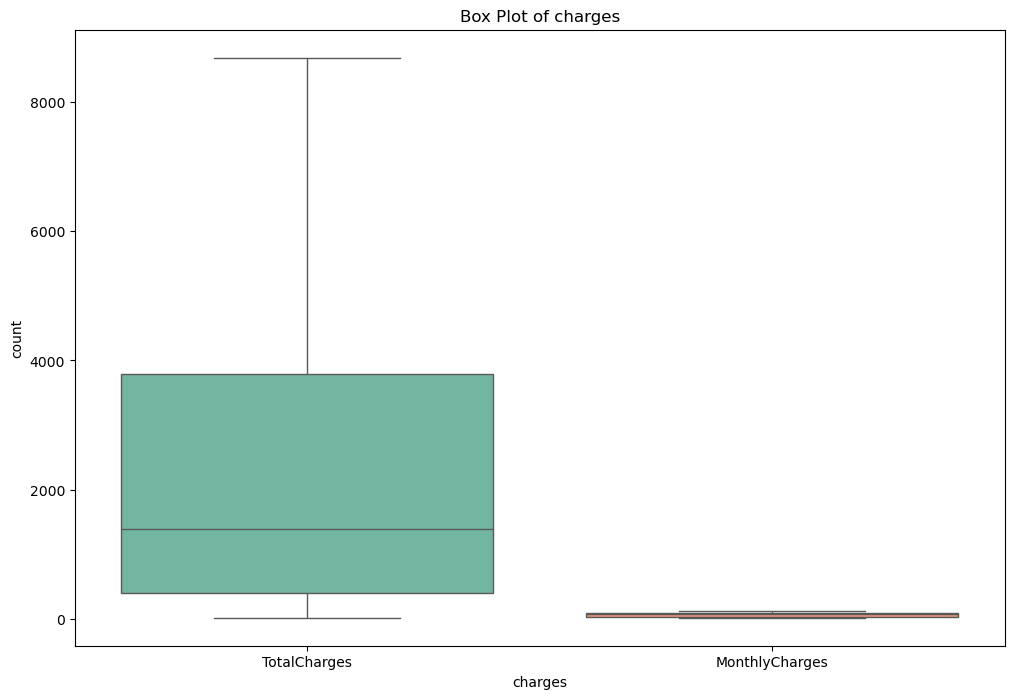

In [27]:
# boxplot 
columns = ["TotalCharges","MonthlyCharges"]
tel.Box_plot(columns)

C:\Users\rosan\AppData\Local\Temp\ipykernel_8976\2227929349.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=self.data, x= col1, y= col2, palette="Set3")


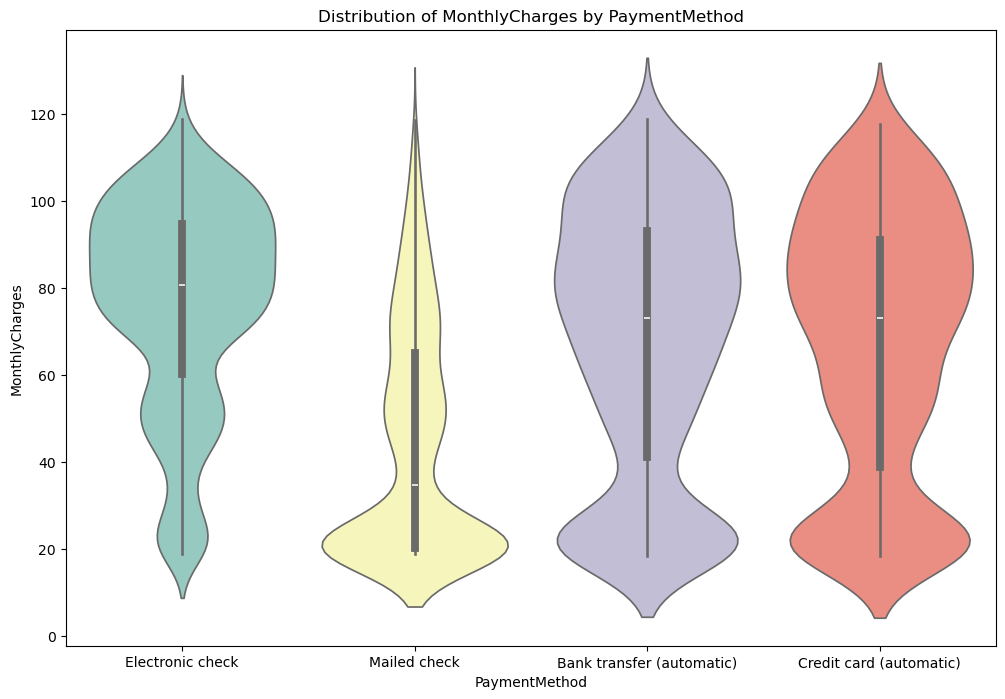

In [28]:
tel.violin_plot("PaymentMethod","MonthlyCharges")

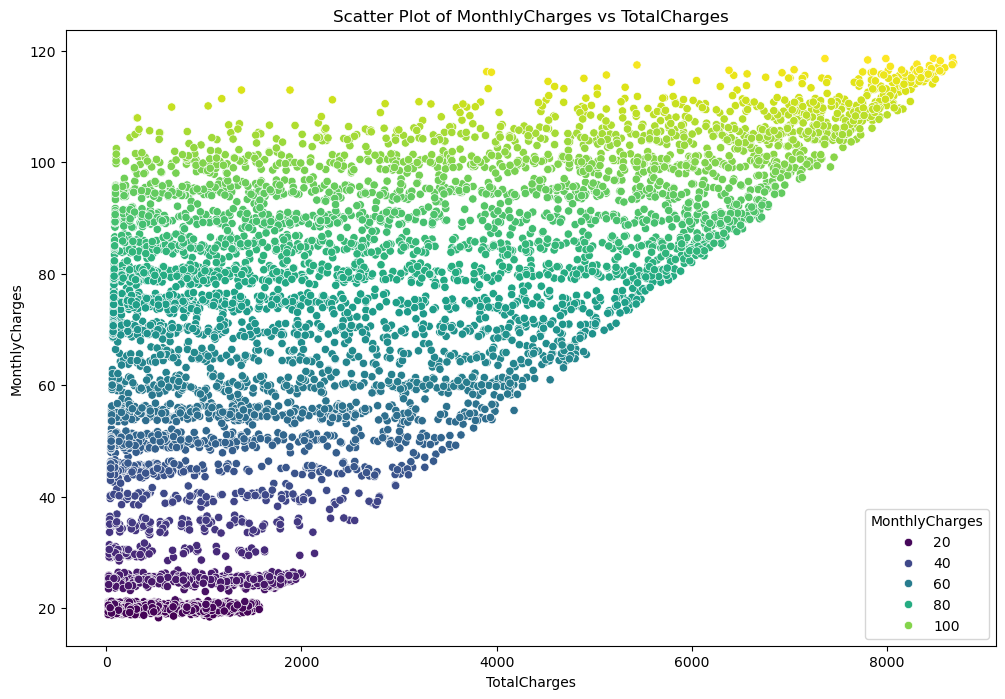

In [29]:
tel.Scatter_plot("TotalCharges","MonthlyCharges")

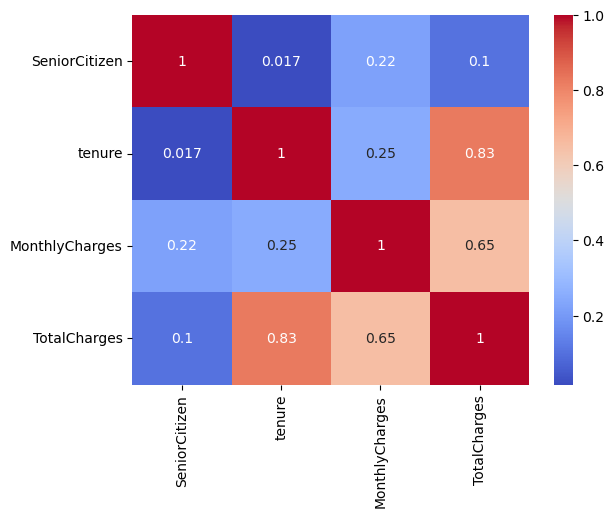

In [30]:
tel.heat_map()

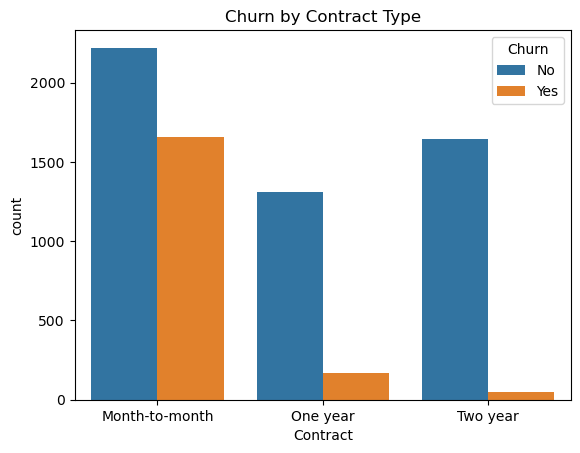

In [31]:
tel.bar_chart_churn_by_contract()

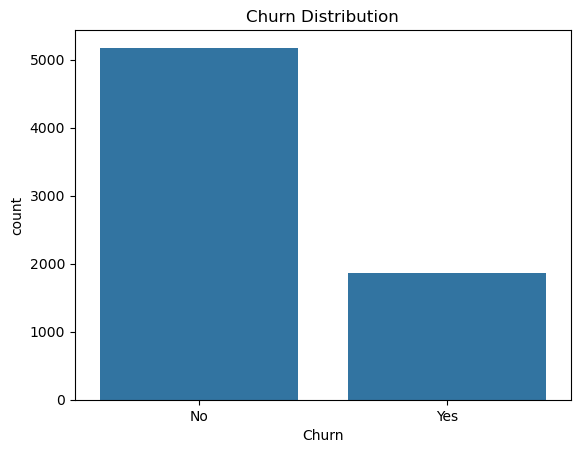

In [32]:
tel.Churn_countplot()

In [33]:
tel.Surface_plot("MonthlyCharges","tenure","TotalCharges")

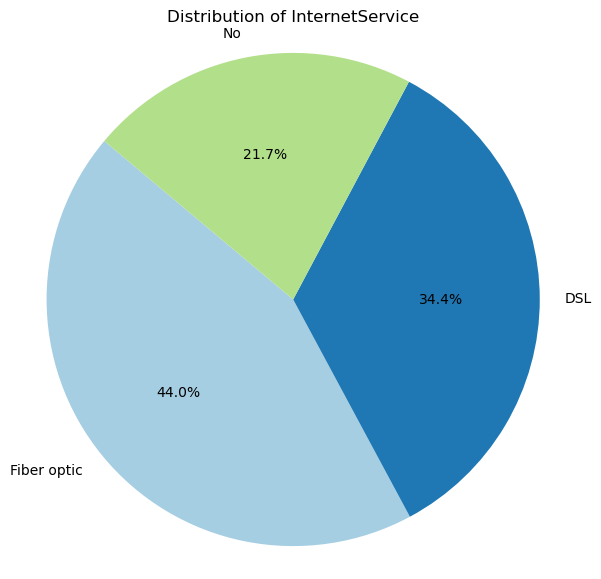

In [34]:
tel.plot_pie_chart("InternetService")

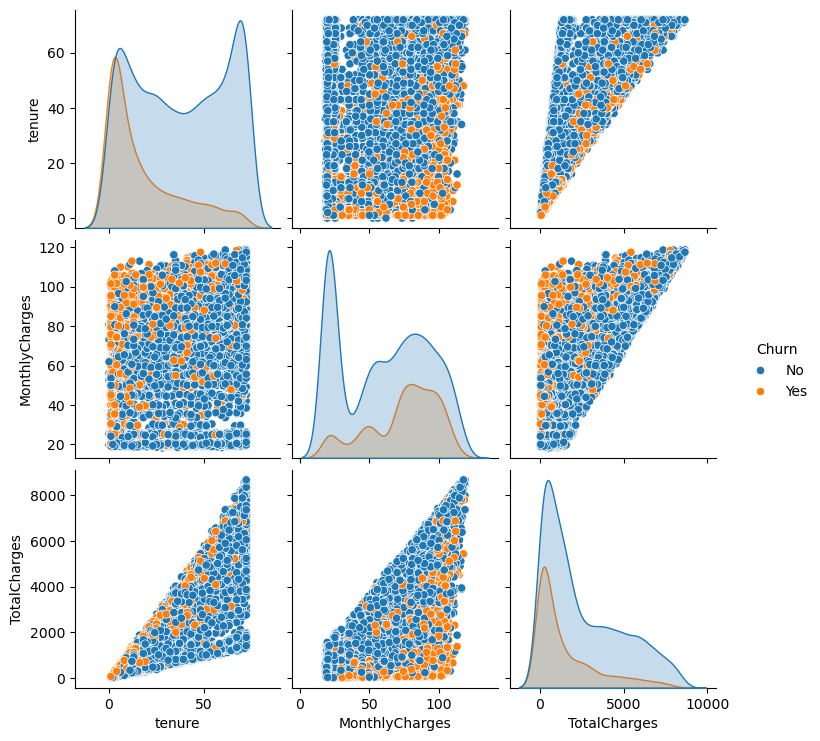

In [35]:
tel.pairplot()

# Connecting python to postgresql

In [36]:
print(tel.generate_create_table_statement())


        CREATE TABLE IF NOT EXISTS telecom_data (
        "gender" TEXT,
    "SeniorCitizen" INT,
    "Partner" TEXT,
    "Dependents" TEXT,
    "tenure" INT,
    "PhoneService" TEXT,
    "MultipleLines" TEXT,
    "InternetService" TEXT,
    "OnlineSecurity" TEXT,
    "OnlineBackup" TEXT,
    "DeviceProtection" TEXT,
    "TechSupport" TEXT,
    "StreamingTV" TEXT,
    "StreamingMovies" TEXT,
    "Contract" TEXT,
    "PaperlessBilling" TEXT,
    "PaymentMethod" TEXT,
    "MonthlyCharges" FLOAT,
    "TotalCharges" FLOAT,
    "Churn" TEXT
        );
        


In [37]:
# Inserting data into postgresql database
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "postgres",
    'host': "localhost",
    'port': "5432"
}
tel.save_to_postgres(conn_params, table_name="telecom_data")

Data inserted successfully into table telecom_data


# Connecting postgresql to python

In [38]:
# Reading the data from postgresql to python
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "postgres",
    'host': "localhost",
    'port': "5432"
}
tel.read_from_postgresql(conn_params, "telecom_data")


C:\Users\rosan\AppData\Local\Temp\ipykernel_8976\2227929349.py:365: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0      7590-VHVEG  Female              0     Yes         No       1   
1      5575-GNVDE    Male              0      No         No      34   
2      3668-QPYBK    Male              0      No         No       2   
3      7795-CFOCW    Male              0      No         No      45   
4      9237-HQITU  Female              0      No         No       2   
...           ...     ...            ...     ...        ...     ...   
35210        None    Male              0     Yes        Yes      24   
35211        None  Female              0     Yes        Yes      72   
35212        None  Female              0     Yes        Yes      11   
35213        None    Male              1     Yes         No       4   
35214        None    Male              0      No         No      66   

      PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0               No  No phone service             DSL             No  ...   
1              Yes                No             DSL            Yes  ...   
2              Yes                No             DSL            Yes  ...   
3               No  No phone service             DSL            Yes  ...   
4              Yes                No     Fiber optic             No  ...   
...            ...               ...             ...            ...  ...   
35210          Yes               Yes             DSL            Yes  ...   
35211          Yes               Yes     Fiber optic             No  ...   
35212           No  No phone service             DSL            Yes  ...   
35213          Yes               Yes     Fiber optic             No  ...   
35214          Yes                No     Fiber optic            Yes  ...   

      DeviceProtection TechSupport StreamingTV StreamingMovies  \
0                   No          No          No              No   
1                  Yes          No          No              No   
2                   No          No          No              No   
3                  Yes         Yes          No              No   
4                   No          No          No              No   
...                ...         ...         ...             ...   
35210              Yes         Yes         Yes             Yes   
35211              Yes          No         Yes             Yes   
35212               No          No          No              No   
35213               No          No          No              No   
35214              Yes         Yes         Yes             Yes   

             Contract PaperlessBilling              PaymentMethod  \
0      Month-to-month              Yes           Electronic check   
1            One year               No               Mailed check   
2      Month-to-month              Yes               Mailed check   
3            One year               No  Bank transfer (automatic)   
4      Month-to-month              Yes           Electronic check   
...               ...              ...                        ...   
35210        One year              Yes               Mailed check   
35211        One year              Yes    Credit card (automatic)   
35212  Month-to-month              Yes           Electronic check   
35213  Month-to-month              Yes               Mailed check   
35214        Two year              Yes  Bank transfer (automatic)   

      MonthlyCharges  TotalCharges Churn  
0              29.85         29.85    No  
1              56.95        1889.5    No  
2              53.85        108.15   Yes  
3              42.30       1840.75    No  
4              70.70        151.65   Yes  
...              ...           ...   ...  
35210          84.80        1990.5    No  
35211         103.20        7362.9    No  
35212          29.60        346.45    No  
35213          74.40         306.6   Yes  
35214         105.65        6844.5    No  

[35215 rows x 21 columns]